----------------------
## IMPORTO LIBRERIE E CARICO FUNZIONI
-----------
-------------

LIBRERIE

In [2]:
import pandas as pd ## dataframes
import yfinance as yf ## for finance
import datetime as dt
import numpy as np ## linear algebra
np.random.seed(11) ## for reproducibility
import matplotlib.pyplot as plt
from scipy import stats ## main python statistical package
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import random
import datetime


IMPORTO FUNZIONI

In [3]:
def diff(X_t, dt):
    N = len(X_t)
    diff_X_t = []
    for i in range(N):
        if i==0:
            diff = (X_t[i+1]-X_t[i])/dt
            diff_X_t.append(diff)
        
        elif i==N-1:
            diff = (X_t[i]-X_t[i-1])/dt
            diff_X_t.append(diff)
            
        else:
            diff_fw = (X_t[i+1]-X_t[i])/dt
            diff_bw = (X_t[i]-X_t[i-1])/dt
            diff = 0.5*(diff_fw+diff_bw)
            diff_X_t.append(diff)
    return diff_X_t
def CrossCorrelationAnalysis(X, Y, maxlag,dt,color1,color2,nome1,nome2,figname):
    """
    Perform the lagged-cross-correlation analysis between two time series X(t) and Y(t).
    X, Y are two 1-d numpy arrays.
    dt is the time step of the time series (default 1 a.u.) - it could be specified w.r.t a given unit
    """
    
    ### Make sure the two time series are stationary
    ### Performing for example the Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    result_X, result_Y = adfuller(X), adfuller(Y)
    if (result_X[1] > 0.05 or result_Y[1]>0.05):
        print("Time Series are not stationary")
        return
    else:
        ## we consider X(t+lag), Y(t)
        ## so that for lag<0 X preceeds Y and vice-versa.
        dim = len(X)
        lags = np.arange(-maxlag, maxlag+1, 1)
        lagged_cross_corr = []
        for lag in lags:
            XY = [(X[t+lag], Y[t]) for t in range(dim-np.abs(lag))]
            X_lagged = [el[0] for el in XY]
            Y_lagged = [el[1] for el in XY]
            lagged_cross_corr.append(stats.pearsonr(X_lagged, Y_lagged)[0])
            
        #plt.figure(figsize=(3, 3), dpi=180)
        lags_min = [l for l in lags if l<=0]
        lags_maj = [l for l in lags if l>=0]
        lcc_min = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]<=0]
        lcc_maj = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]>=0]
        plt.plot(lags_min, lcc_min, lw=3, color=color1)
        plt.plot(lags_maj, lcc_maj, lw=3, color=color2)
        plt.vlines(0, -1, 1, lw=1, ls='--', color='k')
        plt.xlabel('lag temporali',fontsize='16'), plt.ylabel('lagged-cross-correlation',fontsize='16')
        plt.text(-100, 0.8, str(nome1)+' precede '+str(nome2), color=color1,fontsize='16')
        plt.text(5, 0.8, str(nome2)+' precede '+str(nome1), color=color2,fontsize='16')
        corr=lcc_min+lcc_maj
        lag = np.argmax(corr) - maxlag
        if(lag >= 1 ):lag = lag-1
        plt.savefig(str(figname)+'.svg')
        plt.show()
        print('lag = ',lag)
        print('max corr = ',max(lagged_cross_corr))
        
    return lagged_cross_corr   

def normalize(data):
    """
    Normalize a dataset using min-max normalization.
    
    Parameters:
    -----------
    data : pandas.DataFrame or numpy.ndarray
        The dataset to be normalized.
    
    Returns:
    --------
    pandas.DataFrame or numpy.ndarray
        The normalized dataset.
    """
    # compute min and max values for each feature
    min_vals = np.min(data, axis=-1)
    max_vals = np.max(data, axis=-1)
    
    # normalize each feature using min-max normalization
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    
    # convert the result to a pandas.DataFrame if the input was a DataFrame
    if isinstance(data, pd.DataFrame):
        normalized_data = pd.DataFrame(normalized_data, columns=data.columns, index=data.index)
    
    return normalized_data
    
### 1. Check whether the two processes are stationary
### Two common tests are 
### A. Augmented Dickey-Fuller (ADF) Test
### B. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test


### ADF test is conducted with the following assumptions:
### Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
### Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
### If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] > 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")

### The KPSS test is conducted with the following assumptions.
### Null Hypothesis (HO): Series is trend stationary or series has no unit root.
### Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
### Note: The hypothesis is reversed in the KPSS test compared to ADF Test.
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n") 


-----------------
## CARICO DATASETS
------------
----------

In [4]:
stmp = pd.read_csv('STM.csv')
tsmcp = pd.read_csv('TSMC34.SA.csv')
racep = pd.read_csv('RACE.csv')
SeP500p = pd.read_csv('SeP500.csv')

SISTEMO

In [5]:
stmp = stmp.rename(columns={'Adj Close':'stm'})
tsmcp = tsmcp.rename(columns={'Adj Close':'tsmc'})
racep = racep.rename(columns={'Adj Close':'race'})
SeP500p = SeP500p.rename(columns={'Adj Close' : 'SeP500'})

stm = stmp['stm']
tsmc = tsmcp['tsmc']
race = racep['race']
SeP500 = SeP500p['SeP500']

PLOT DATA


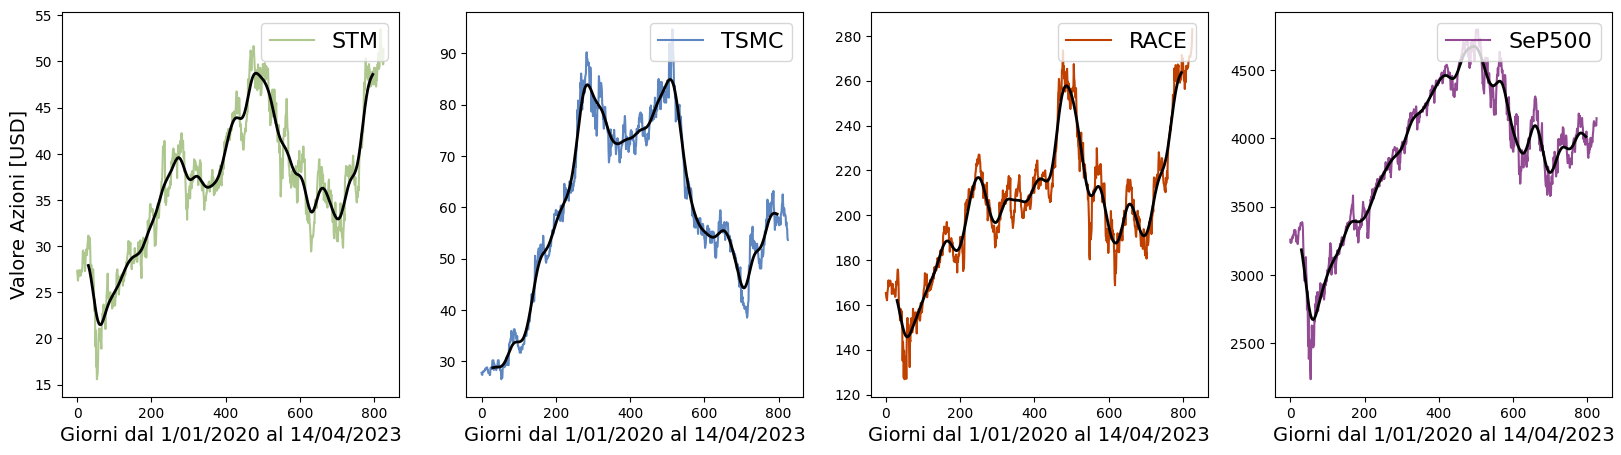

In [6]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
anni=list(range(0,826))
ax[0].plot(anni,stm,color='#9AB973',label='STM',alpha=0.8)
ax[0].plot(anni,stm.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[0].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[0].set_ylabel('Valore Azioni [USD]',fontsize='14')
ax[1].plot(anni,tsmc,color='#5E86C1',label='TSMC')
ax[1].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[1].plot(anni,tsmc.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[2].plot(anni,race,color='#C04000',label='RACE')
ax[2].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[2].plot(anni,race.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[3].plot(anni,SeP500,color='#660066',label='SeP500',alpha=0.7)
ax[3].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[3].plot(anni,SeP500.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[0].legend(fontsize='16',loc='upper right'),ax[1].legend(fontsize='16',loc='upper right'),ax[2].legend(fontsize='16',loc='upper right'),ax[3].legend(fontsize='16',loc='upper right')
plt.savefig('grafici.svg')

-------------
## DETRENDING
------
----------

In [7]:
tsmc

0      27.716400
1      27.362989
2      27.326834
3      27.940346
4      27.893690
         ...    
821    57.099998
822    56.150002
823    55.750000
824    53.900002
825    53.639999
Name: tsmc, Length: 826, dtype: float64

DIFFERENZIO

In [8]:
d_tsmc = diff(tsmc,1)
d_stm = diff(stm,1)
d_race = diff(race,1)
d_SeP500 = diff(SeP500,1)

d_stm=np.nan_to_num(d_stm)
d_tsmc=np.nan_to_num(d_tsmc)
d_race=np.nan_to_num(d_race)
d_SeP500=np.nan_to_num(d_SeP500)

MEDIA MOBILE

In [9]:
#lag top 60
lag=120
stm_medio = stm.rolling(lag, center=True,win_type='hamming').mean()
tsmc_medio = tsmc.rolling(lag,center=True,win_type='hamming').mean()
race_medio = race.rolling(lag, center=True, win_type='hamming').mean()
SeP500_medio = SeP500.rolling(lag, center=True, win_type='hamming').mean()

dt=4
d_stm = stm.rolling(dt,center=True,win_type='hamming').mean() - stm_medio
d_tsmc = tsmc.rolling(dt,center=True,win_type='hamming').mean() - tsmc_medio
d_race = race.rolling(dt,center=True,win_type='hamming').mean() - race_medio
d_SeP500 = SeP500.rolling(dt, center=True,win_type='hamming').mean() - SeP500_medio

d_stm=np.nan_to_num(d_stm)
d_tsmc=np.nan_to_num(d_tsmc)
d_race=np.nan_to_num(d_race)
d_SeP500=np.nan_to_num(d_SeP500)

NORMALIZZO

In [10]:
d_stm = normalize(d_stm)
d_tsmc = normalize(d_tsmc)
d_race = normalize (d_race)
d_SeP500 = normalize (d_SeP500)


PLOT DETRENDING

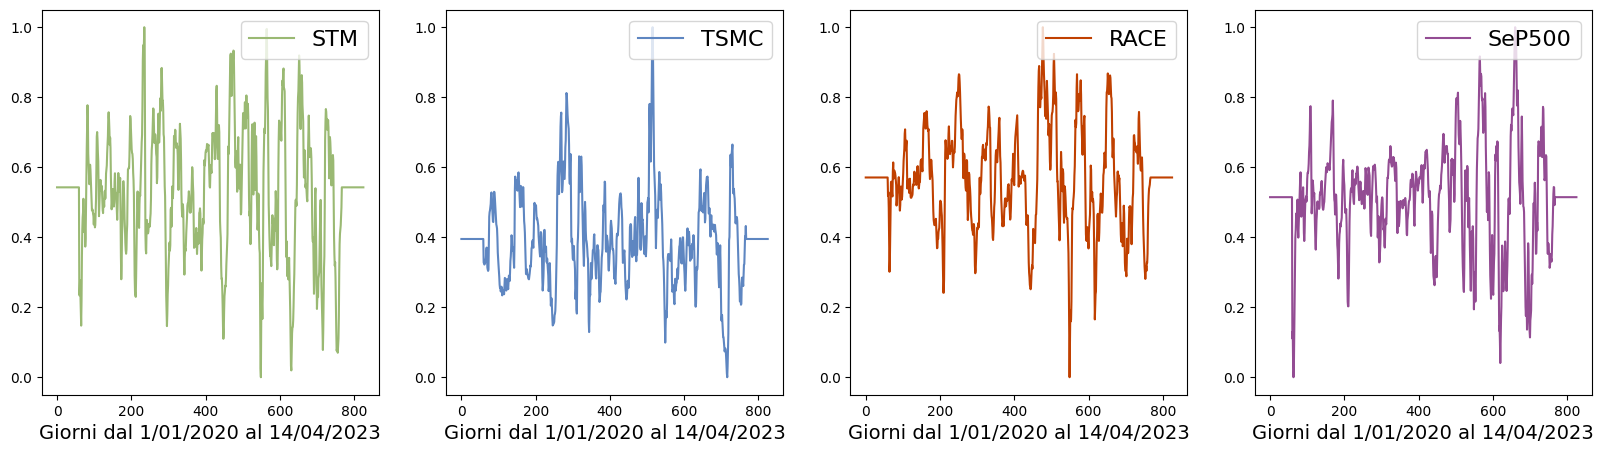

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
anni=list(range(0,826))
ax[0].plot(anni,d_stm,color='#9AB973',label='STM')
ax[0].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[1].plot(anni,d_tsmc,color='#5E86C1',label='TSMC')
ax[1].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[2].plot(anni,d_race,color='#C04000',label='RACE')
ax[2].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[3].plot(anni,d_SeP500,color='#660066',label='SeP500',alpha=0.7)
ax[3].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[0].legend(fontsize='16',loc='upper right'),ax[1].legend(fontsize='16',loc='upper right'),ax[2].legend(fontsize='16',loc='upper right'),ax[3].legend(fontsize='16',loc='upper right')
plt.savefig('grafici1.svg')

TESTO STAZIONARIETA' CON ADF E KPSS TEST

In [12]:
print('---------------------')
print('STAZIONARIETA\' STM :')
print('---------------------')
adf_test(d_stm)
kpss_test(d_stm)
print('----------------------')
print('STAZIONARIETA\' TSMC :')
print('----------------------')
adf_test(d_tsmc)
kpss_test(d_tsmc)
print('----------------------')
print('STAZIONARIETA\' RACE :')
print('----------------------')
adf_test(d_race)
kpss_test(d_race)
print('------------------------')
print('STAZIONARIETA\' SeP500 :')
print('------------------------')
adf_test(d_SeP500)
kpss_test(d_SeP500)

---------------------
STAZIONARIETA' STM :
---------------------
Results of Dickey-Fuller Test:
Test Statistic                -7.495207e+00
p-value                        4.398164e-11
#Lags Used                     9.000000e+00
Number of Observations Used    8.160000e+02
Critical Value (1%)           -3.438389e+00
Critical Value (5%)           -2.865088e+00
Critical Value (10%)          -2.568660e+00
dtype: float64

*** Time series is stationary ***

Results of KPSS Test:
Test Statistic            0.085449
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

*** Time series is stationary ***

----------------------
STAZIONARIETA' TSMC :
----------------------
Results of Dickey-Fuller Test:


/home/andrea/Scrivania/Labo_comp/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic                  -5.591051
p-value                          0.000001
#Lags Used                      13.000000
Number of Observations Used    812.000000
Critical Value (1%)             -3.438429
Critical Value (5%)             -2.865106
Critical Value (10%)            -2.568669
dtype: float64

*** Time series is stationary ***

Results of KPSS Test:
Test Statistic            0.064069
p-value                   0.100000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

*** Time series is stationary ***

----------------------
STAZIONARIETA' RACE :
----------------------
Results of Dickey-Fuller Test:
Test Statistic                -5.795929e+00
p-value                        4.752226e-07
#Lags Used                     1.700000e+01
Number of Observations Used    8.080000e+02
Critical Value (1%)           -3.438469e+00
Critical Value (5%

/home/andrea/Scrivania/Labo_comp/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/andrea/Scrivania/Labo_comp/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Test Statistic                -6.605168e+00
p-value                        6.584467e-09
#Lags Used                     3.000000e+00
Number of Observations Used    8.220000e+02
Critical Value (1%)           -3.438330e+00
Critical Value (5%)           -2.865063e+00
Critical Value (10%)          -2.568646e+00
dtype: float64

*** Time series is stationary ***

Results of KPSS Test:
Test Statistic            0.03413
p-value                   0.10000
#Lags Used               17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64

*** Time series is stationary ***



/home/andrea/Scrivania/Labo_comp/venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


--------------
## CROSS CORRELATION
----------
-----------

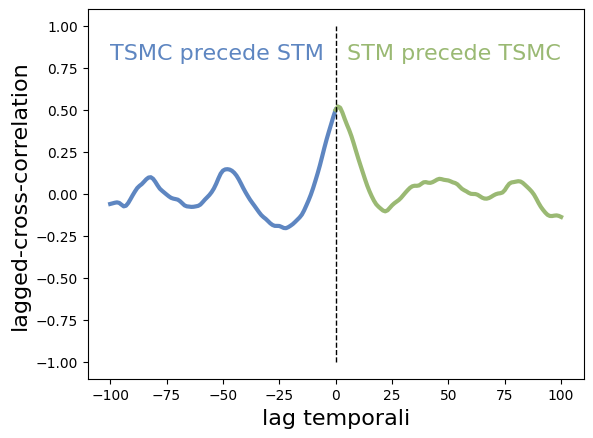

lag =  1
max corr =  0.5206015374564198


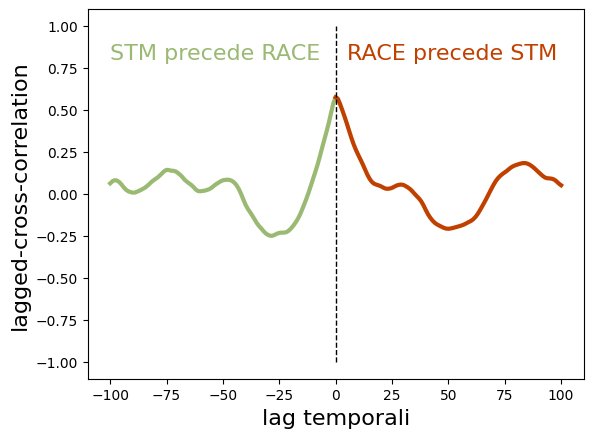

lag =  0
max corr =  0.5748456598489654


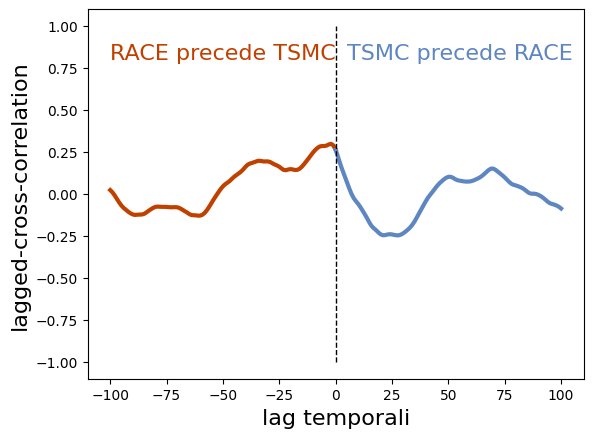

lag =  -2
max corr =  0.2979442250833886


In [13]:
lag=100
corr1 = CrossCorrelationAnalysis(d_tsmc,d_stm, lag,1,color1='#5E86C1',color2='#9AB973',nome1='TSMC',nome2='STM',figname='corr1')
corr2 = CrossCorrelationAnalysis(d_stm,d_race, lag,1,color1='#9AB973',color2='#C04000',nome1='STM',nome2='RACE',figname='corr2')
corr3 = CrossCorrelationAnalysis(d_race,d_tsmc, lag,1,color1='#C04000',color2='#5E86C1',nome1='RACE',nome2='TSMC',figname='corr3')


---------------------
## SHUFFLE DATI E CROSS CORRELATION

--------------


In [14]:
import random

def shuffle_copy(arr):
    arr_copy = arr.copy()
    random.shuffle(arr_copy)
    return arr_copy


In [15]:
d_stm_shuffle = shuffle_copy(d_stm)
d_tsmc_shuffle = shuffle_copy(d_tsmc)
d_race_shuffle = shuffle_copy(d_race)
d_SeP500_shuffle = shuffle_copy(d_SeP500)


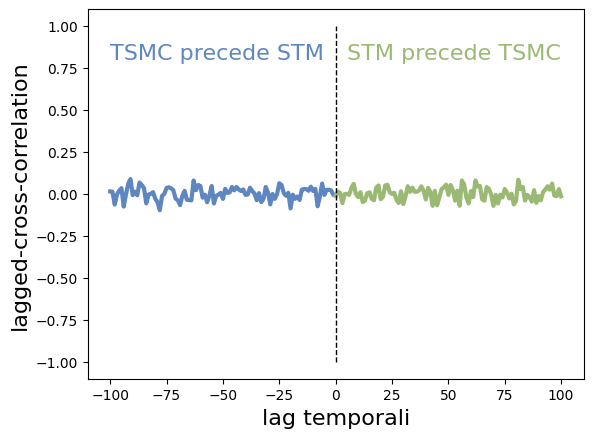

lag =  -91
max corr =  0.08871251744387977


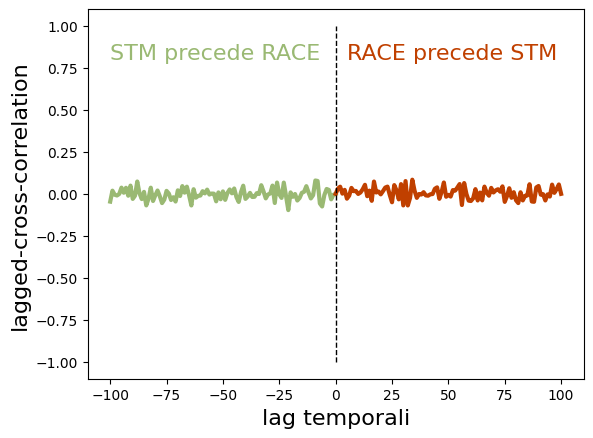

lag =  34
max corr =  0.08464641559003361


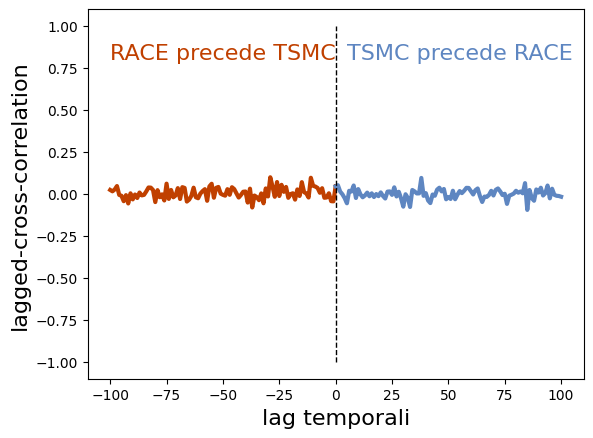

lag =  -29
max corr =  0.09899732910528788


In [16]:
lag=100
corr1 = CrossCorrelationAnalysis(d_tsmc_shuffle,d_stm_shuffle, lag,1,color1='#5E86C1',color2='#9AB973',nome1='TSMC',nome2='STM',figname='corr1_shuffle')
corr2 = CrossCorrelationAnalysis(d_stm_shuffle,d_race_shuffle, lag,1,color1='#9AB973',color2='#C04000',nome1='STM',nome2='RACE',figname='corr2_shuffle')
corr3 = CrossCorrelationAnalysis(d_race_shuffle,d_tsmc_shuffle, lag,1,color1='#C04000',color2='#5E86C1',nome1='RACE',nome2='TSMC',figname='corr3_shuffle')

----------------
## GRANGER CAUSALITY
------------
------------

TROVO I LAG OTTIMALI 

-----------------

In [17]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,30)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     13
BIC      4
HQIC     8
FPE     13
dtype: int64


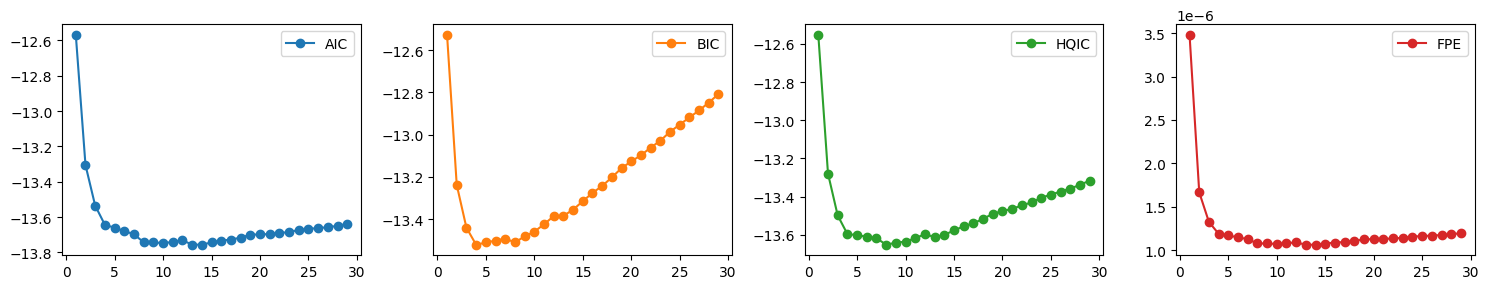

In [18]:
data=pd.concat([pd.Series(d_stm),pd.Series(d_tsmc)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_stm_tsmc.svg')

AIC     18
BIC      6
HQIC     8
FPE     18
dtype: int64


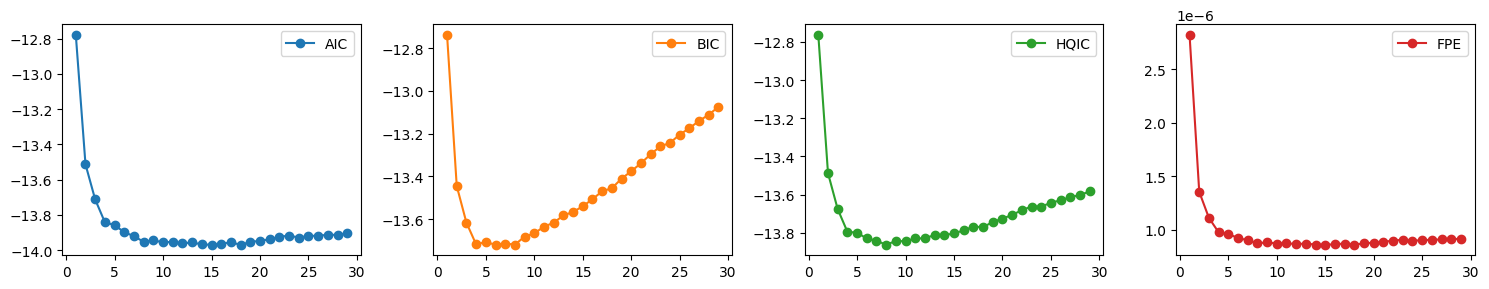

In [19]:
data=pd.concat([pd.Series(d_stm),pd.Series(d_race)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_stm_race.svg')

AIC     14
BIC      8
HQIC     8
FPE     14
dtype: int64


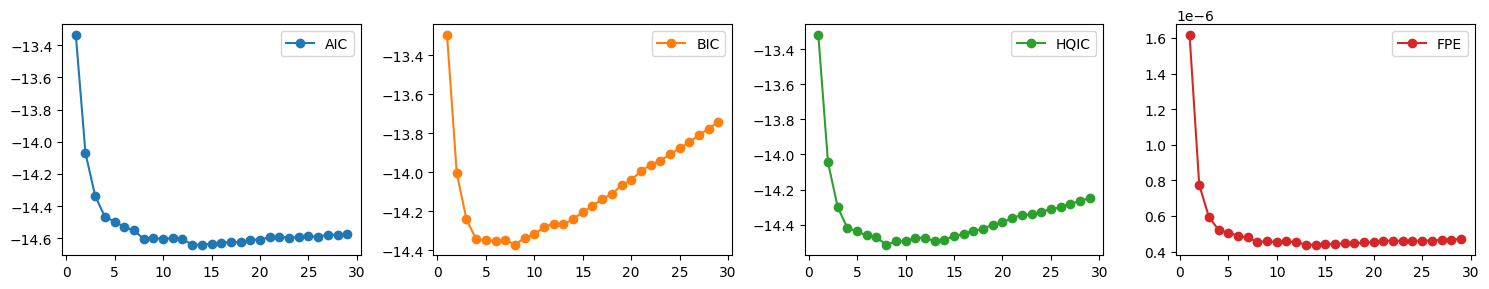

In [20]:
data=pd.concat([pd.Series(d_tsmc),pd.Series(d_race)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_race_tsmc.svg')

---------------
GC:  STM -> TSMC

--------------------

In [21]:
maxlag=[14]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_tsmc,'column2': d_stm})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')



Lag: 14
Granger causality p-value: 1.006085592820226e-07


---------------
GC:  TSMC->STM

--------------------

In [22]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_stm,'column2': d_tsmc})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')



Lag: 14
Granger causality p-value: 0.7948982474194622


---------------
GC:  RACE->STM

--------------------

In [23]:
maxlag=[8]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_stm,'column2': d_race})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')


Lag: 8
Granger causality p-value: 0.23532638985823545


---------------
GC:  STM->RACE

--------------------

In [24]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_race,'column2': d_stm})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 8
Granger causality p-value: 0.003413978003544154


---------------
GC:  TSMC->RACE

--------------------

In [25]:
maxlag=[13]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_race,'column2': d_tsmc})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.0922810684058648


---------------
GC:  RACE->TSMC

--------------------

In [26]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_tsmc,'column2': d_race})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.0004474221662608427


---------
## CERCO VARIABILE NASCOSTA
-----------
----------

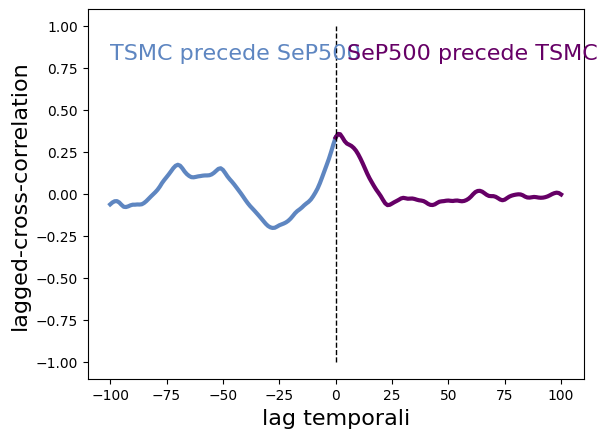

lag =  1
max corr =  0.35716505883201616


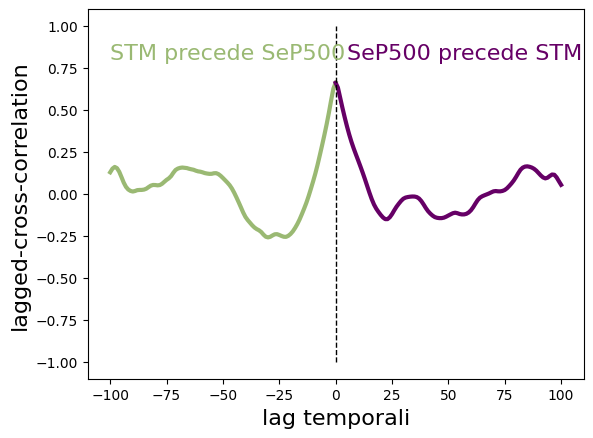

lag =  0
max corr =  0.6611680710410084


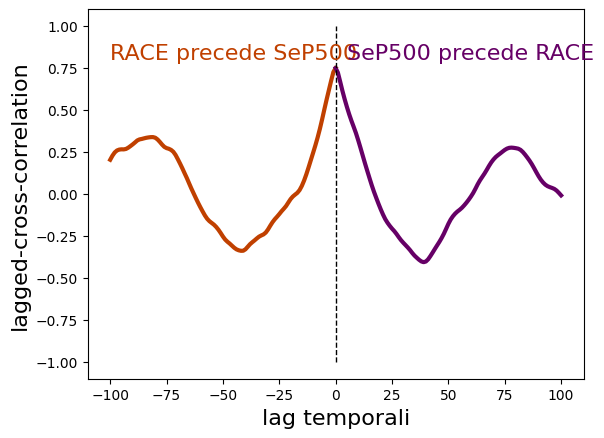

lag =  0
max corr =  0.7488040375984697


In [27]:
lag=100
corr1 = CrossCorrelationAnalysis(d_tsmc,d_SeP500,lag,1,color1='#5E86C1',color2='#660066',nome1='TSMC',nome2='SeP500',figname='corrse1')
corr2 = CrossCorrelationAnalysis(d_stm,d_SeP500, lag,1,color1='#9AB973',color2='#660066',nome1='STM',nome2='SeP500',figname='corrse2')
corr3 = CrossCorrelationAnalysis(d_race,d_SeP500, lag,1,color1='#C04000',color2='#660066',nome1='RACE',nome2='SeP500',figname='corrse3')

---------
## GRANGER CAUSALITY
-------
-------

TROVO I LAG OTTIMALI 

-----------------

AIC     14
BIC      8
HQIC     8
FPE     14
dtype: int64


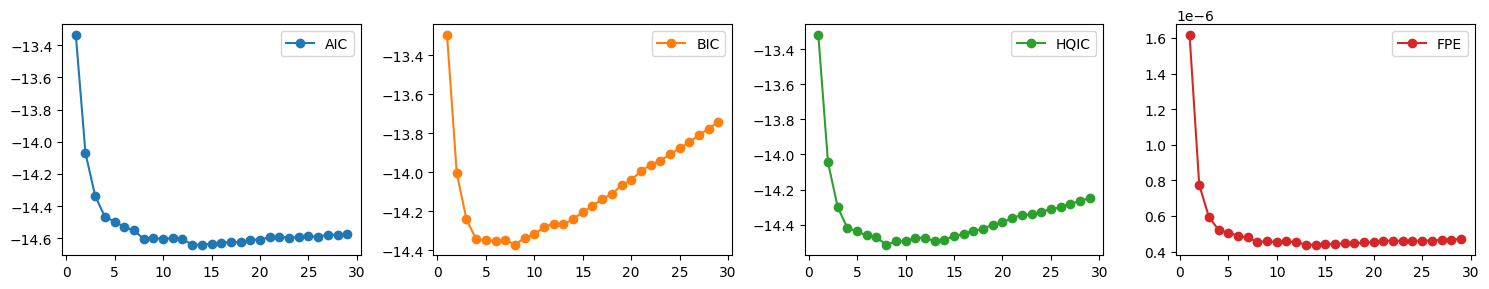

In [28]:
data=pd.concat([stm,SeP500], axis=1)
traindf, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_stm_sep500.svg')

AIC     14
BIC      8
HQIC     8
FPE     14
dtype: int64


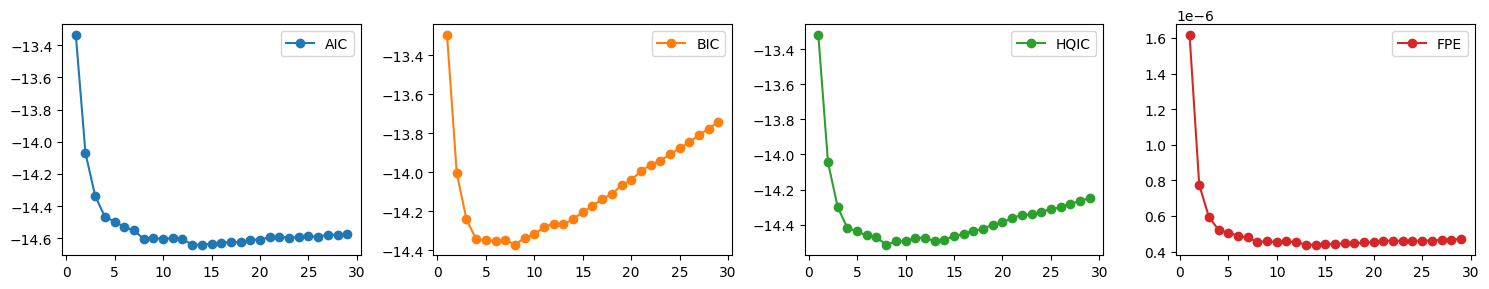

In [29]:
data=pd.concat([tsmc,SeP500], axis=1)
traindf, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_tsmc_sep500.svg')

AIC     14
BIC      8
HQIC     8
FPE     14
dtype: int64


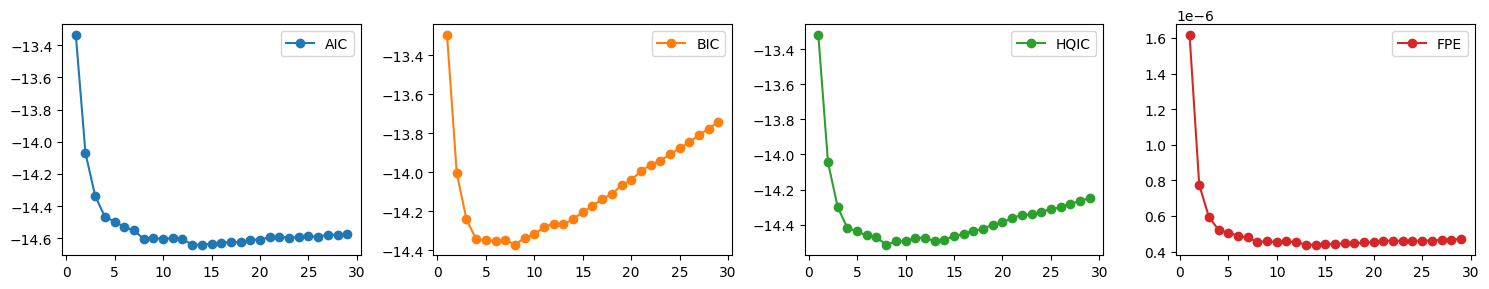

In [30]:
data=pd.concat([race,SeP500], axis=1)
traindf, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_race_sep500.svg')

-----------
SeP500->STM

---------

In [31]:
maxlag=[13]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_stm,'column2': d_SeP500})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.00011422208178133959


-----------
STM->SeP500

---------

In [32]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_SeP500,'column2': d_stm})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.3051206036865968


-----------
SeP500->TSMC

---------

In [33]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_tsmc,'column2': d_SeP500})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 8.147026073999758e-07


-----------
TSMC->SeP500

---------

In [34]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_SeP500,'column2': d_tsmc})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.7642073399677592


----------
SeP500->RACE

------------

In [35]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_race,'column2': d_SeP500})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 1.1472269320890452e-07


-------
RACE->SeP500

--------

In [36]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_SeP500,'column2': d_race})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 5.251691878267667e-09


------------------------
## CONTROLLO I RESIDUI PER AUTOCORRELAZIONE
------------------
-----------------------

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, May, 2023
Time:                     17:44:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.6948
Nobs:                     822.000    HQIC:                  -13.7584
Log likelihood:           3356.25    FPE:                1.01765e-06
AIC:                     -13.7980    Det(Omega_mle):     9.95726e-07
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.012208         0.003448            3.540           0.000
L1.column1         1.724893         0.034243           50.372           0.000
L1.column2         0.115909         0.022115            5.241         

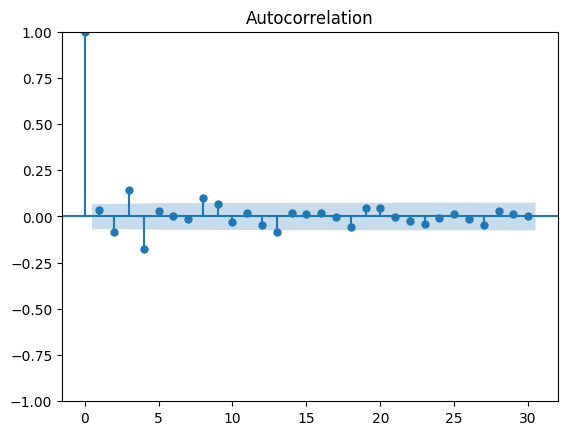

In [37]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_tsmc,'column2': d_stm})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, May, 2023
Time:                     17:44:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.9509
Nobs:                     822.000    HQIC:                  -14.0145
Log likelihood:           3461.47    FPE:                7.87789e-07
AIC:                     -14.0540    Det(Omega_mle):     7.70817e-07
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.025715         0.006186            4.157           0.000
L1.column1         1.711651         0.038963           43.931           0.000
L1.column2         0.129013         0.059901            2.154         

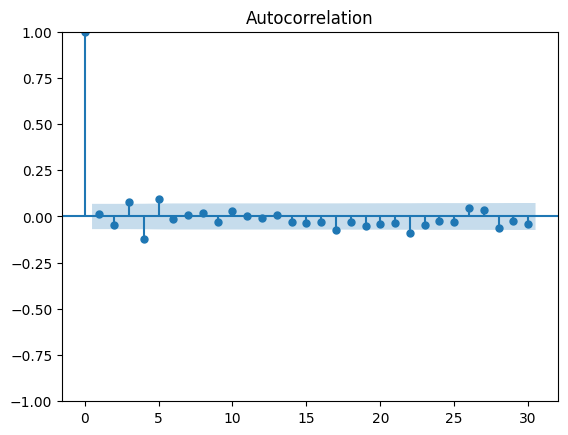

In [38]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_stm,'column2': d_race})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, May, 2023
Time:                     17:44:38
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.5326
Nobs:                     822.000    HQIC:                  -14.5962
Log likelihood:           3700.55    FPE:                4.40332e-07
AIC:                     -14.6357    Det(Omega_mle):     4.30846e-07
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.009699         0.004444            2.183           0.029
L1.column1         1.760191         0.034006           51.761           0.000
L1.column2         0.094371         0.034490            2.736         

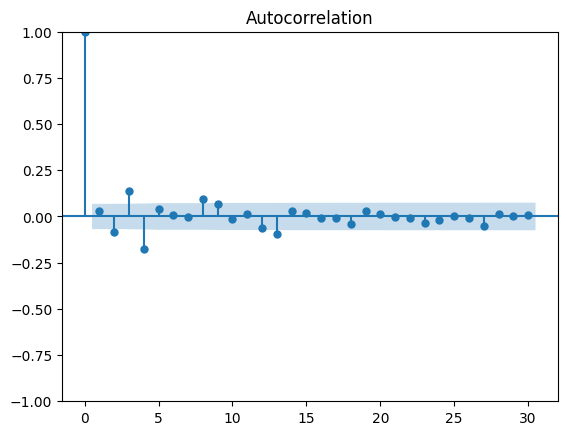

In [39]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_tsmc,'column2': d_race})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, May, 2023
Time:                     17:44:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.6173
Nobs:                     822.000    HQIC:                  -13.6809
Log likelihood:           3324.36    FPE:                1.09974e-06
AIC:                     -13.7204    Det(Omega_mle):     1.07605e-06
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.033394         0.005652            5.908           0.000
L1.column1         1.812772         0.045296           40.021           0.000
L1.column2        -0.098148         0.052017           -1.887         

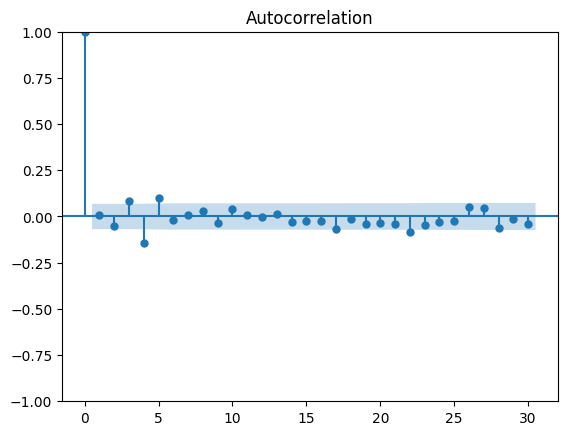

In [40]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_stm,'column2': d_SeP500})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, May, 2023
Time:                     17:44:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.8942
Nobs:                     822.000    HQIC:                  -13.9578
Log likelihood:           3438.17    FPE:                8.33742e-07
AIC:                     -13.9973    Det(Omega_mle):     8.15781e-07
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.011489         0.004020            2.858           0.004
L1.column1         1.750343         0.034006           51.472           0.000
L1.column2         0.098913         0.025518            3.876         

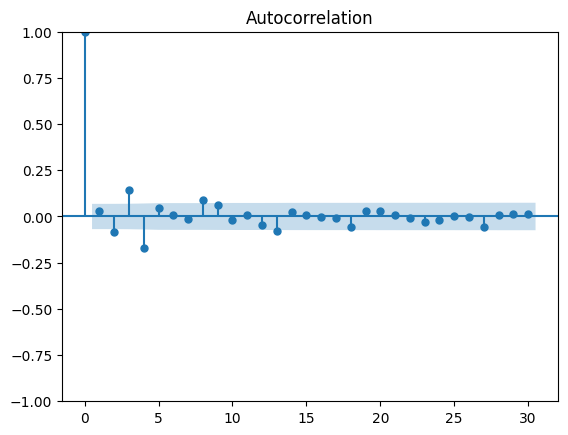

In [41]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_tsmc,'column2': d_SeP500})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)



df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, May, 2023
Time:                     17:44:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.4001
Nobs:                     822.000    HQIC:                  -14.4637
Log likelihood:           3646.12    FPE:                5.02687e-07
AIC:                     -14.5033    Det(Omega_mle):     4.91858e-07
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.023209         0.003978            5.834           0.000
L1.column1         1.894705         0.043278           43.780           0.000
L1.column2        -0.068961         0.032554           -2.118         

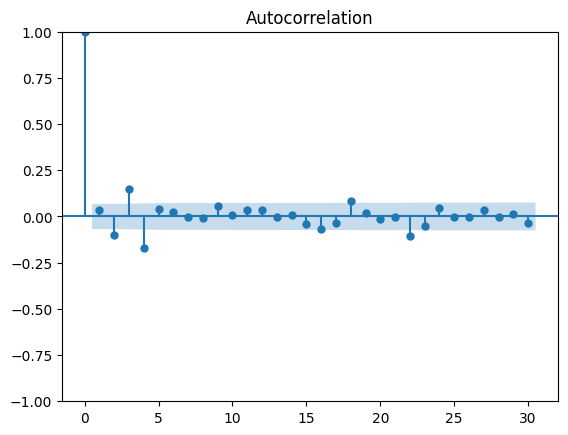

In [42]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_race,'column2': d_SeP500})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))